In [1]:
from __future__ import print_function, division
from collections import Counter
import os
import time
import json
import sqlite3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from jupyterthemes import jtplot
jtplot.style(theme="chesterish")

src = "data"

In [2]:
t0 = time.clock()
info = pd.read_csv(os.path.join(src, "format1", "user_info_format1.csv"))
print('load user info\nruntime:', time.clock() - t0)

t0 = time.clock()
info.gender[pd.isnull(info.gender)] = 2  # if the a user's gender column was null = 2, see also doc
info.age_range[pd.isnull(info.age_range)] = 0  # if the a user's age_range column was null = 0, see also doc
info.age_range[info.age_range == 8] = 7  # age_range 8 was equal to the 7, see also doc
print("nclean null space of gender & age, set age 8 to 7\nruntime:", time.clock() - t0)

t0 = time.clock()
df = pd.read_csv(os.path.join(src, "format1", "user_log_format1.csv"))
print('\nload user log\nruntime:', time.clock() - t0)

# t0 = time.clock()
# cross_by_user_item_action = pd.crosstab([df.user_id, df.item_id], df.action_type)
# print('\ncreate cross table\nruntime:', time.clock() - t0)

t0 = time.clock()
cross_user_seller_act = pd.crosstab([df.user_id, df.seller_id], df.action_type)
print("runtime:", time.clock() - t0)

load user info
runtime: 0.365436446025
nclean null space of gender & age, set age 8 to 7
runtime: 0.182324199423


C:\Anaconda2\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Anaconda2\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
C:\Anaconda2\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  



load user log
runtime: 64.086150058

create cross table
runtime: 403.789854085
runtime: 211.187370169


In [3]:
t0 = time.clock()
# merge the user infomation to the user log
data = pd.merge(df, info, how='left', on='user_id')
print("merge users' info to users' log runtime:", time.clock() - t0)
# # slice 100,000 data to explore
# crosstab_slice = crosstab_by_user_item_action.iloc[:100000, :]
# # merge the user infomation to the cross table (user, item x action)
# data_slice = pd.merge(crosstab_slice.reset_index(), info, how='left', on=['user_id'])

runtime: 39.645767395


0.0    285638
1.0    121670
2.0     16862
Name: gender, dtype: int64
number of users' infomation: 424170
number of users' gebder    : 424170


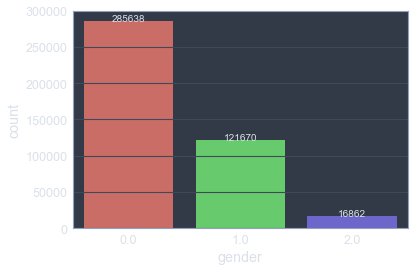

In [4]:
# Gender of user
info_gender = info['gender'].value_counts()
print(info_gender)
print("number of users' infomation:", info.shape[0])
print("number of users' gebder    :", info_gender.sum())
fig = plt.figure()
sns.countplot(x='gender', data=info, palette='hls')
for i in info_gender.index:
    plt.text(i, info_gender[i], info_gender[i], ha='center')
    
plt.show()
fig.savefig('image/gender.png')

3.0    111654
0.0     95131
4.0     79991
2.0     52871
5.0     40777
6.0     35464
7.0      8258
1.0        24
Name: age_range, dtype: int64
number of users' infomation: 424170
number of users' age range : 424170


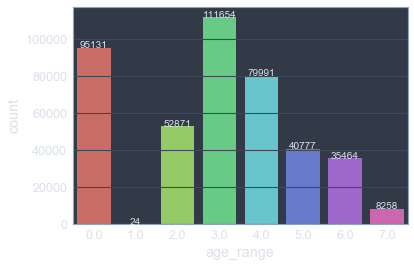

In [17]:
# Age Range of user
info_age_range = info['age_range'].value_counts()
print(info_age_range)
print("number of users' infomation:", info.shape[0])
print("number of users' age range :", info_age_range.sum())
fig = plt.figure()
sns.countplot(x='age_range', data=info, palette='hls')
for i in info_age_range.index:
    plt.text(i, info_age_range[i], info_age_range[i], ha='center')
plt.show()
fig.savefig('image/age_range.png')

Text(0,0.5,'Frequency')

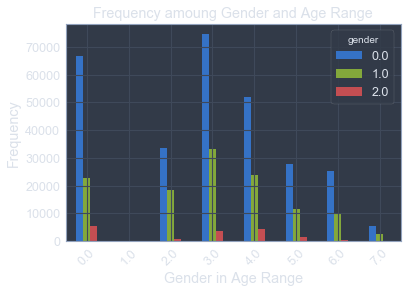

In [6]:
# Frequency amoung Gender and Age Range
pd.crosstab(info.age_range, info.gender).plot(kind='bar')
plt.title('Frequency amoung Gender and Age Range')
plt.xticks(rotation=45)
plt.xlabel('Gender in Age Range')
plt.ylabel('Frequency')

gender,0.0,1.0,2.0
action_type,,,
0,35547307,10814066,2189340
1,47719,23743,5288
2,2329907,811342,150895
3,2388245,486379,131099


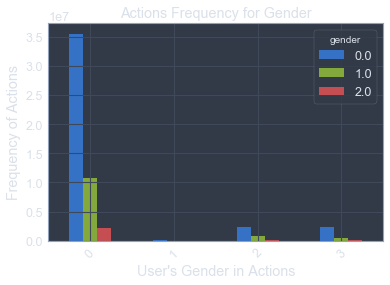

In [7]:
# Frequency of Actions to Gender
pd.crosstab(data.action_type, data.gender).plot(kind='bar')
plt.title('Actions Frequency for Gender')
plt.xticks(rotation=45)
plt.xlabel("User's Gender in Actions")
plt.ylabel('Frequency of Actions')
pd.crosstab(data.action_type, data.gender)

age_range,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0
action_type,,,,,,,,
0,8919409,1512,4694010,13079874,10411758,5509918,4843730,1090502
1,24828,2,7230,18084,12386,6695,6279,1246
2,592622,96,295262,865659,769541,396683,308718,63563
3,522526,111,388518,885020,608367,286704,254989,59488


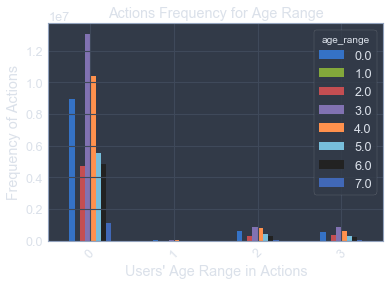

In [8]:
# Frequency of Actions to age
pd.crosstab(data.action_type, data.age_range).plot(kind='bar')
plt.title('Actions Frequency for Age Range')
plt.xticks(rotation=45)
plt.xlabel("Users' Age Range in Actions")
plt.ylabel('Frequency of Actions')
pd.crosstab(data.action_type, data.age_range)

In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve


def sigmoid(x):
    return 1.0 / (1 + np.exp(-x))


def explaintory_variables(x, w):
    intercept = np.ones((x.shape[0], 1))
    x_1 = np.concatenate((intercept, x), axis=1)
    return x_1.dot(w)


def roc_graph(fpr, tpr, y_hat, y):
    plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % roc_auc_score(y, y_hat))
    plt.plot([0, 1], [0, 1],'w--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()

C:\Anaconda2\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Anaconda2\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


runtime: 49.2867957117
-2.156  0.115  0.215  -0.145  0.008  0.109


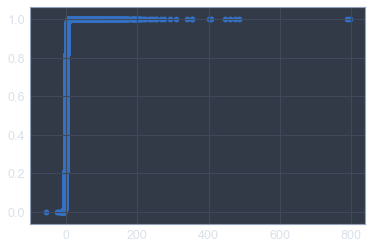

In [21]:
data_new = pd.merge(cross_user_seller_act, info, how='left', on="user_id").reset_index()
data_new[2][data_new[2]>0] = 1
lr = LogisticRegression()

x = data_new.iloc[:, [2, 3, 5, 6, 7]]
y = data_new[2]
y[y > 0] = 1

t0 = time.clock()
lr.fit(x, y)
print("runtime:", time.clock() - t0)

w = [lr.intercept_[0]] + [i for i in lr.coef_[0]]
print("  ".join(map(lambda i: "%.3f" % (i), w)))

t = explaintory_variables(x, w)
p = sigmoid(t)
plt.scatter(t, p)
plt.show()

roc_auc_score:  0.550501083005883


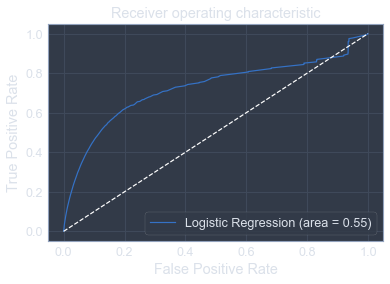

In [37]:
# yhat = 1 if predict probability > 0.5 else 0
y_hat = lr.predict(x)
print("roc_auc_score: ", roc_auc_score(y, y_hat))

# where lr.predict_proba(x)[:,1] is sigmoid(t)
fpr, tpr, thresholds = roc_curve(y, lr.predict_proba(x)[:,1])

# graph ROC curve
roc_graph(fpr, tpr, y_hat, y)